In [1]:
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)
print("Working directory:", os.getcwd())

Working directory: c:\Users\benjo\OneDrive\Data Science Masters\DSMP\dsmp-2024-group-19


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import *
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [3]:
# load csv of tape data
raw_data = read_merged_data()
tape1 = raw_data[0]
tape1 = tape1.dropna(subset=["Last Tapes Price"])

Opening UoB_Set01_2025-01-02tapes.csv


In [4]:
print(tape1.head())

                                      Incoming bid  \
combined_time                                        
2025-01-02 08:00:10                [193 15][267 5]   
2025-01-02 08:00:11  [118 10][267 3][96 10][46 10]   
2025-01-02 08:00:12   [92 10][127 1][264 1][181 1]   
2025-01-02 08:00:13                                  
2025-01-02 08:00:14                        [10 10]   

                                                          Incoming ask  \
combined_time                                                            
2025-01-02 08:00:10               [275 8] [277 2][584 3][269 1][268 1]   
2025-01-02 08:00:11  [281 6][274 3] [275 5][270 5][464 3][273 3][30...   
2025-01-02 08:00:12                      [744 3][270 3][280 4] [281 2]   
2025-01-02 08:00:13                       [269 3][282 2][268 3][278 4]   
2025-01-02 08:00:14  [272 5][296 3][271 5][423 5][270 3][644 5][376...   

                               Outgoing bid  \
combined_time                                 
2025-01-

<AxesSubplot:xlabel='combined_time'>

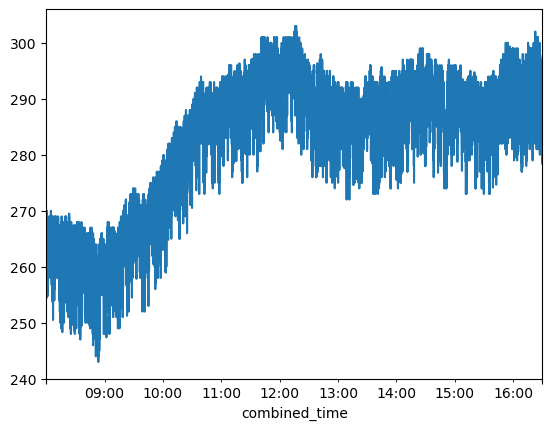

In [5]:
tape1['Last Tapes Price'].plot()

In [6]:
result = adfuller(tape1['Last Tapes Price'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -3.853514
p-value: 0.002405


As p-value is less than 0.05 then model can be assumed stationary and no differencing is needed - this may not hold for less granular data

In [7]:
from pmdarima.arima.utils import ndiffs
ndiffs(tape1['Last Tapes Price'].dropna(), test='adf')

0

Confirm the significant number of differencing is 0.

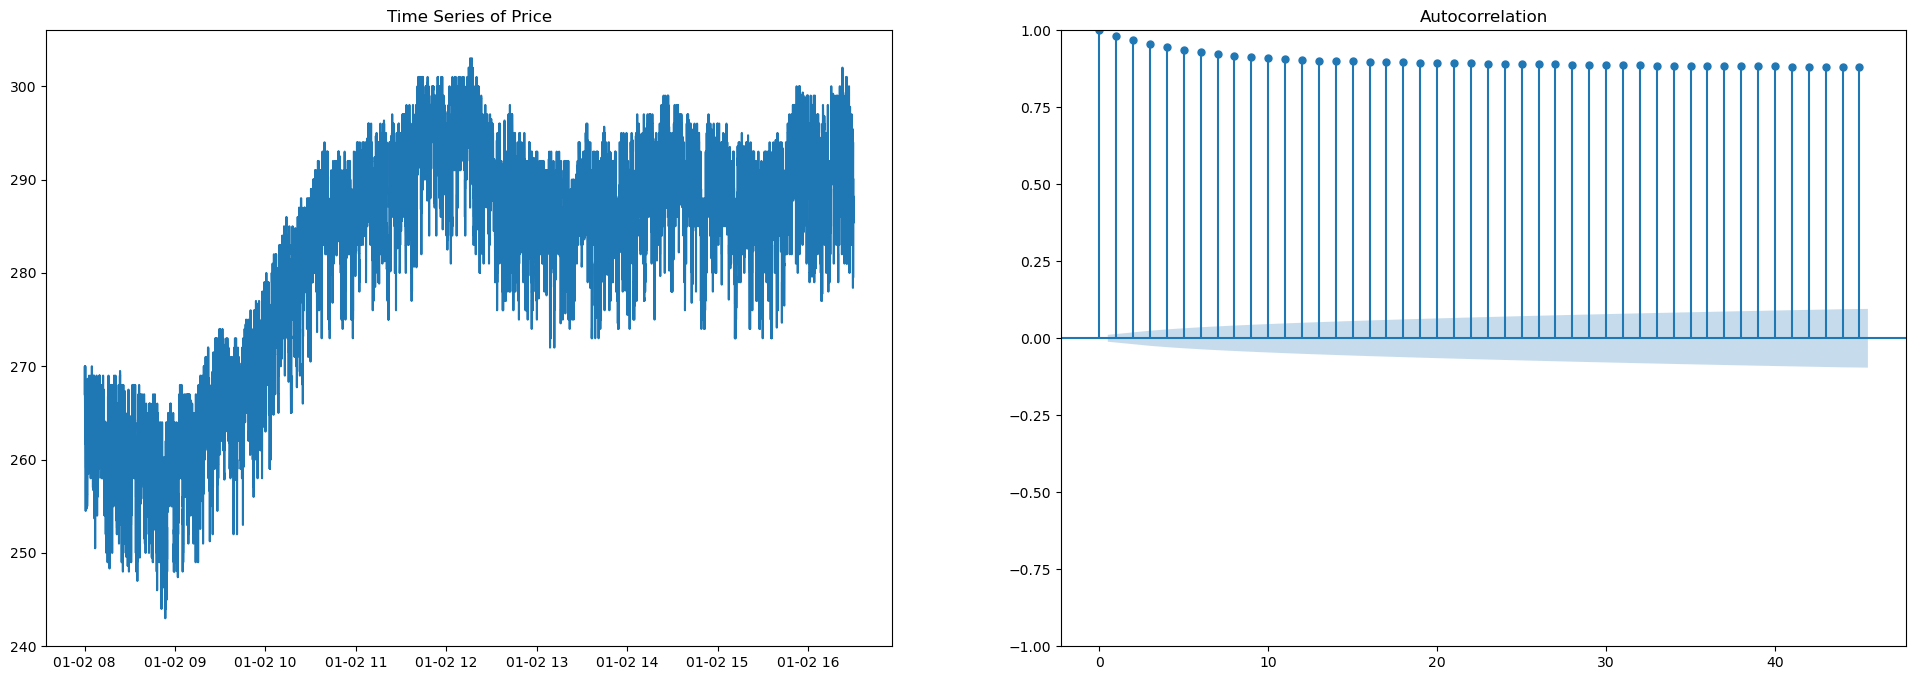

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(tape1['Last Tapes Price'])
ax1.set_title('Time Series of Price')
plot_acf(tape1['Last Tapes Price'], ax=ax2);

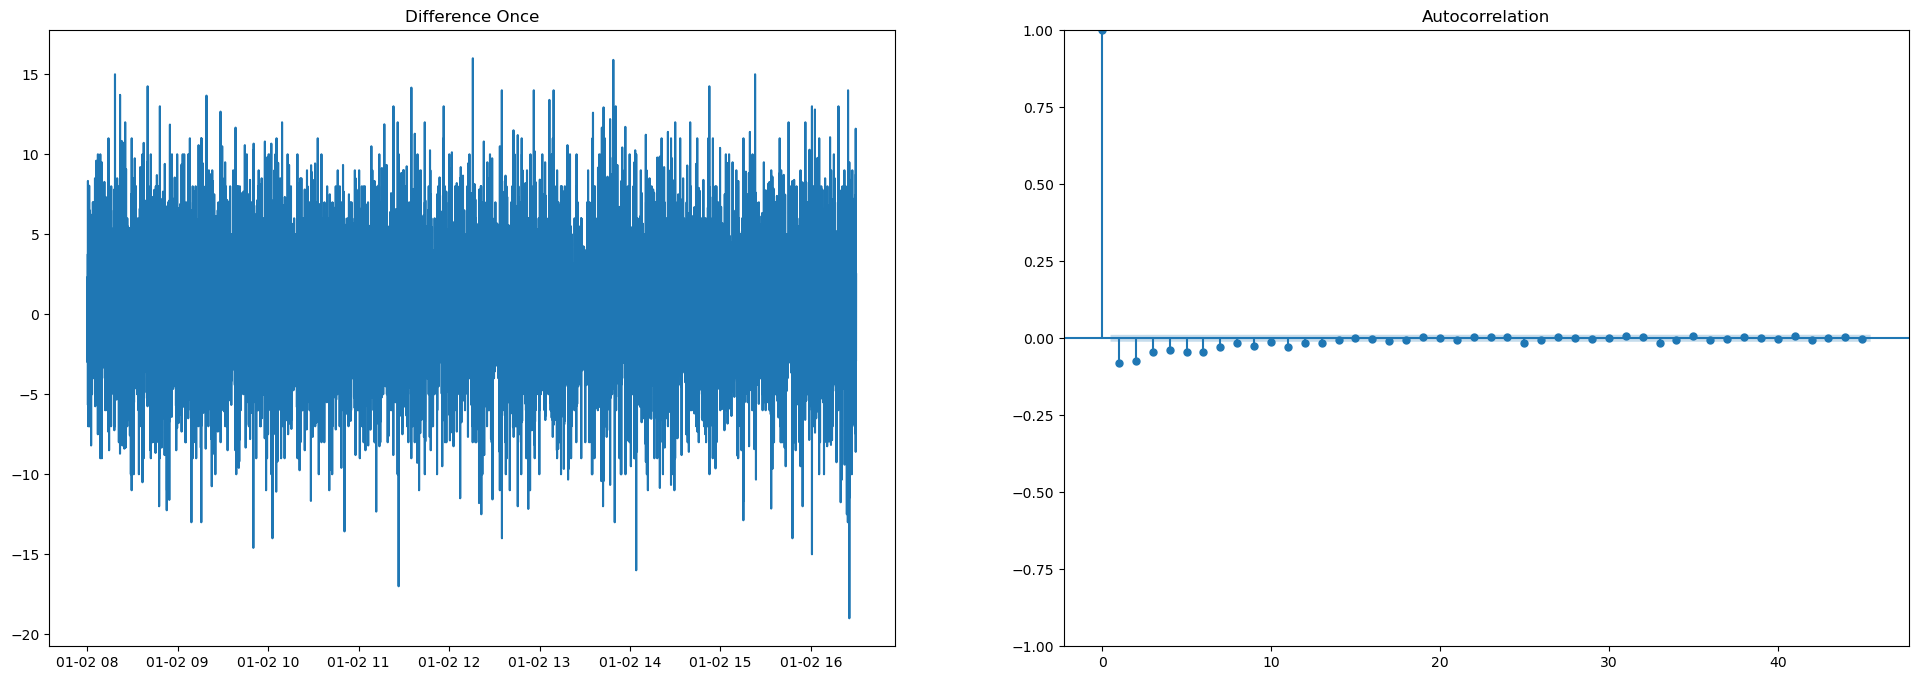

In [9]:
diff = tape1['Last Tapes Price'].diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);

Differencing provides a series more celearly centred around mean 0. This will be used for the further investigation despite the original data passing the ADF test. 

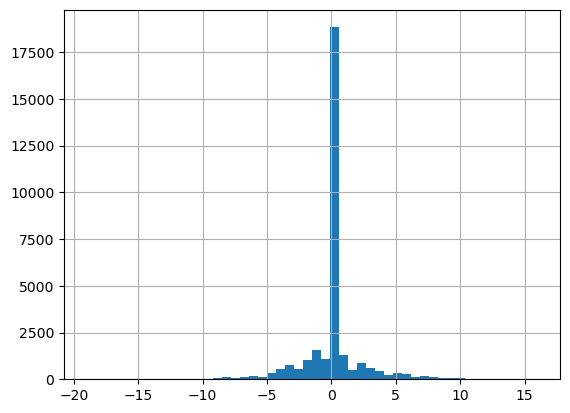

In [10]:
# histogram of differences
diff.hist(bins=50);

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


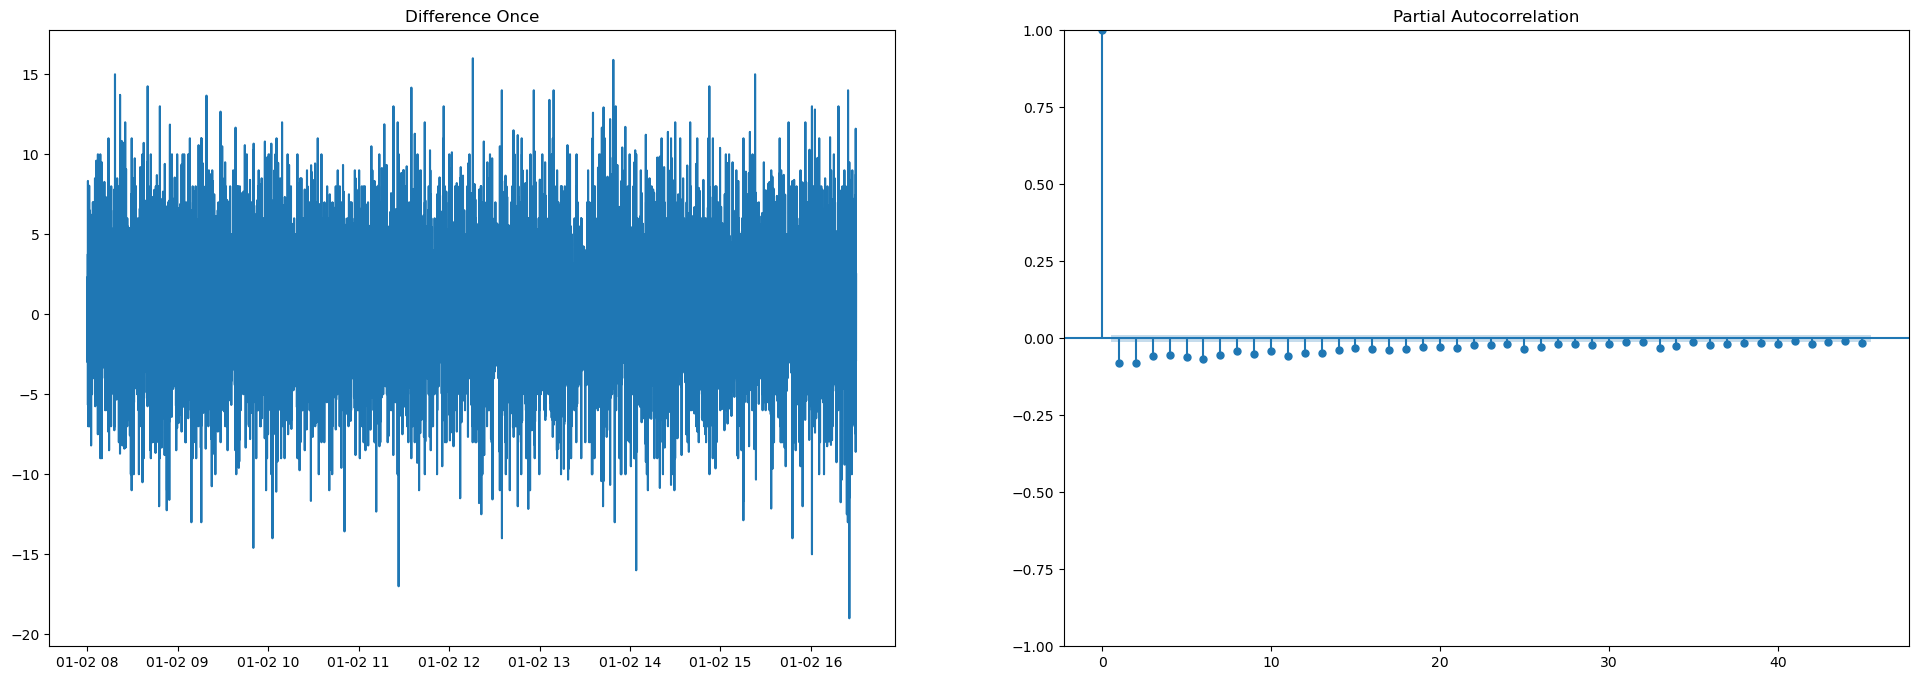

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_pacf(diff, ax=ax2);

Significant lags in the Auto-Regressive model which begin to die down at order 18. This pacf plot can be used to select the p value of the model.

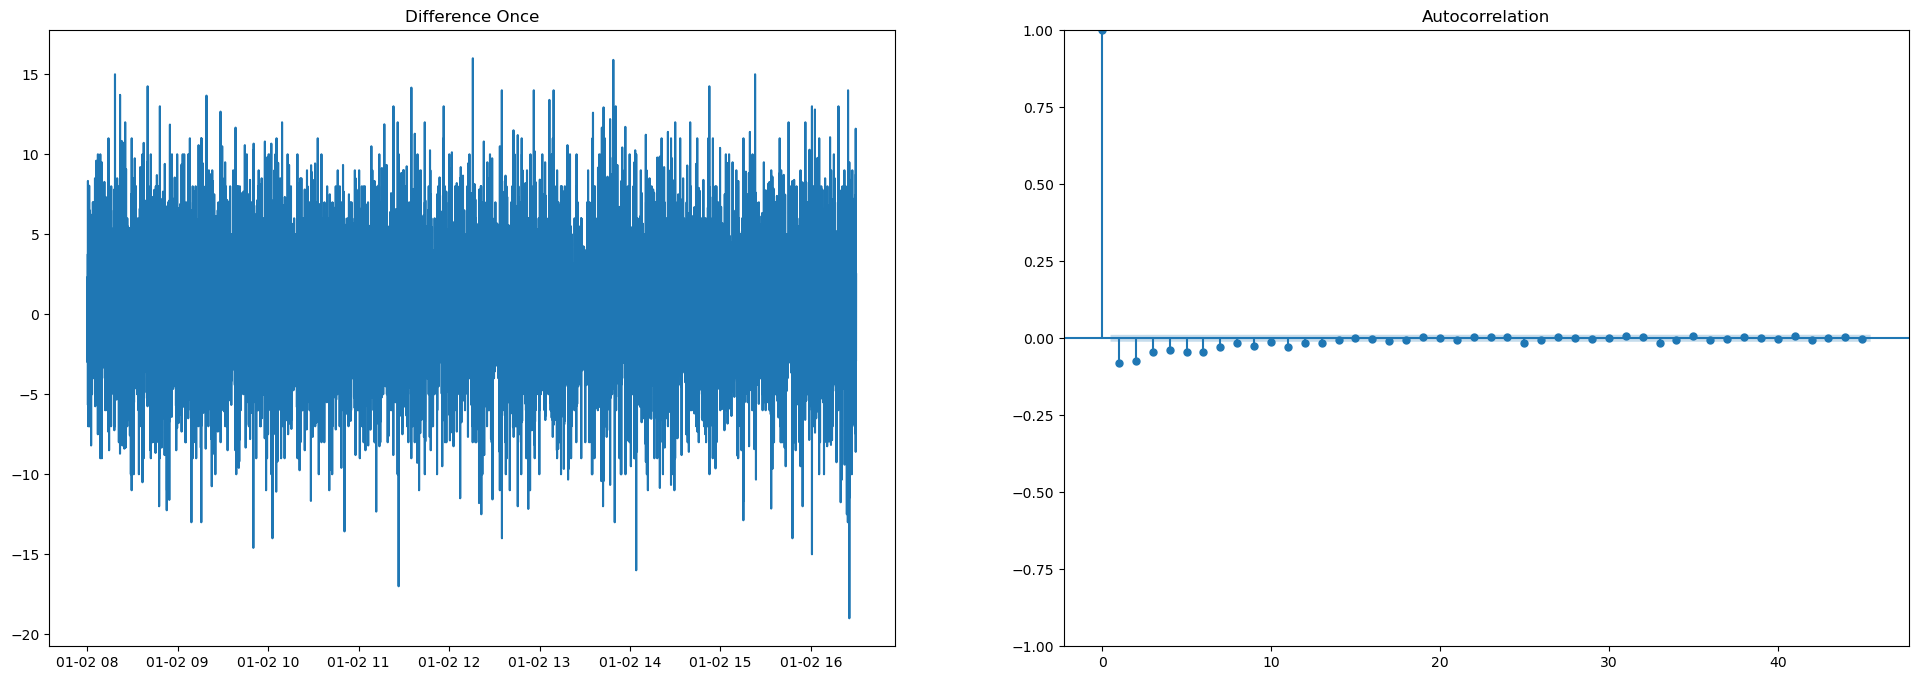

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);


Significant lags in Moving Average model until lag 6. This can be used to choose q.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model
model = ARIMA(tape1['Last Tapes Price'], order=(1,0,1))
result = model.fit()

Experimenting with standard (1,0,1) ARIMA model

In [14]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:       Last Tapes Price   No. Observations:                30590
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -68965.168
Date:                Wed, 17 Apr 2024   AIC                         137938.336
Time:                        13:06:43   BIC                         137971.650
Sample:                    01-02-2025   HQIC                        137949.015
                         - 01-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.6643      0.850    331.502      0.000     279.999     283.330
ar.L1          0.9856      0.001   1007.350      0.000       0.984       0.988
ma.L1         -0.0854      0.006    -14.916      0.0

Coefficient values are too small and P values are far too high, meaning the components of the model aer not significant enough so need to increase order of AR model and test performance again.

P values are much better in this model and coefficient values higher.

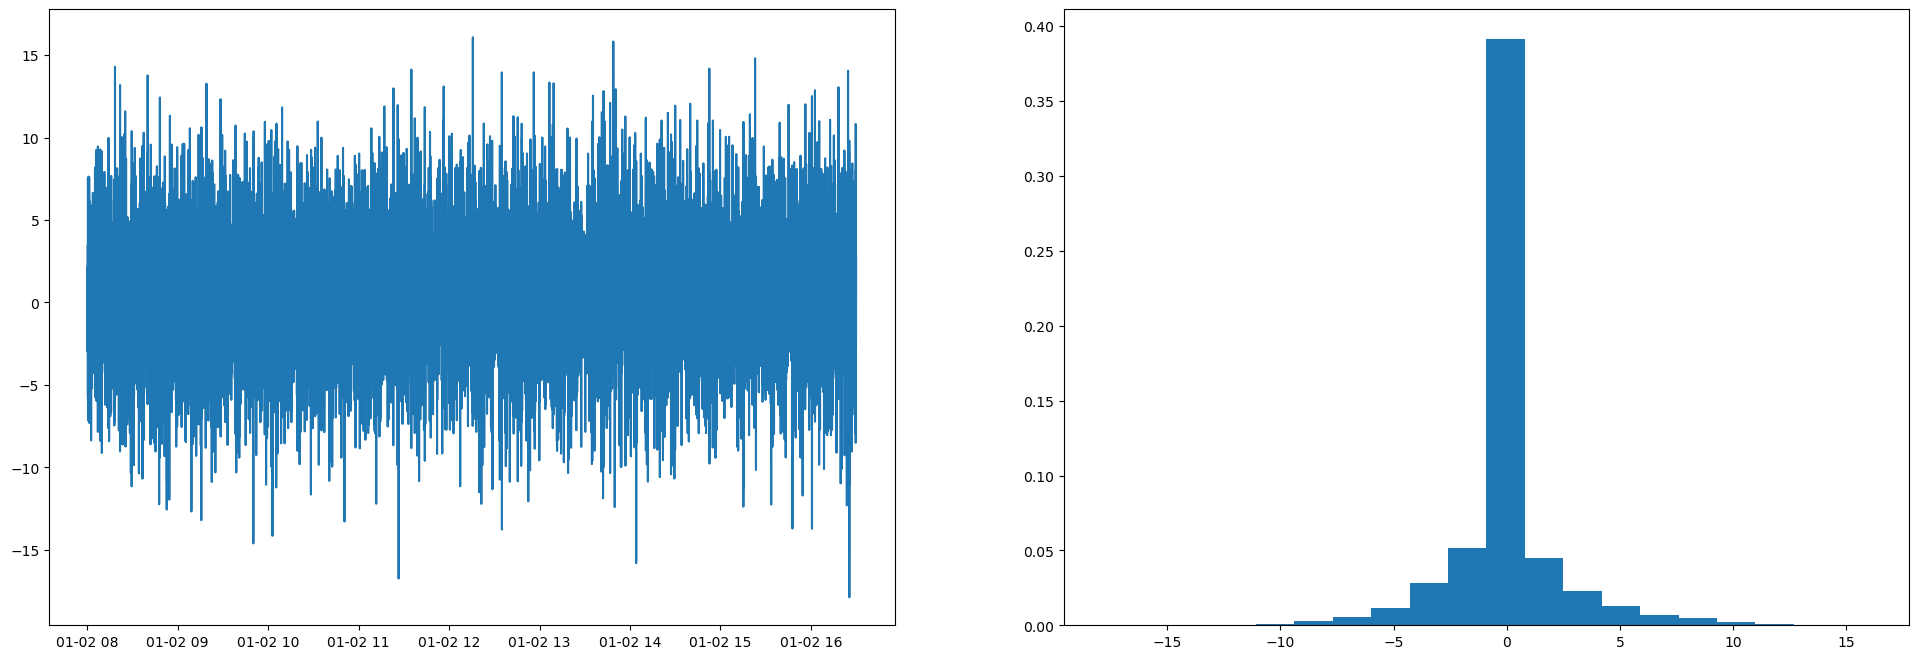

In [15]:
residuals = pd.DataFrame(result.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals[1:])
ax2.hist(residuals[1:], density=True, bins=20);



Text(0.5, 1.0, 'ARIMA Predictions for first 100 time stamps of Tape 1')

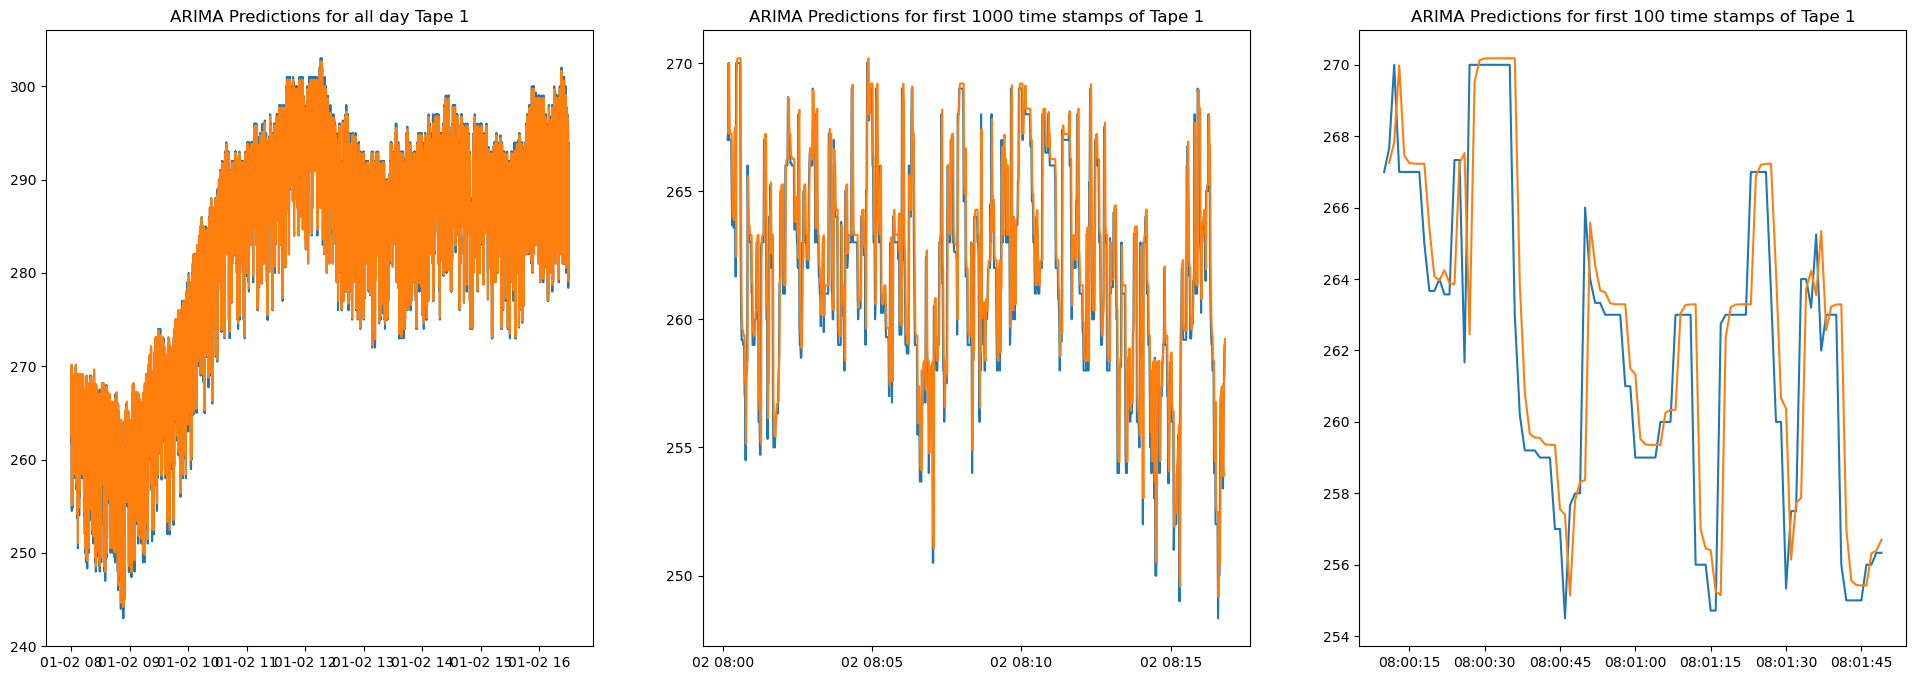

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))


pred = result.predict(start=0, end=len(tape1)-1)
ax1.plot(tape1['Last Tapes Price'])
ax1.plot(pred[1:])
ax1.set_title('ARIMA Predictions for all day Tape 1')

ax2.plot(tape1['Last Tapes Price'][:1000])
ax2.plot(pred[1:1000])
ax2.set_title('ARIMA Predictions for first 1000 time stamps of Tape 1')



ax3.plot(tape1['Last Tapes Price'][:100])
ax3.plot(pred[1:100]) 
ax3.set_title('ARIMA Predictions for first 100 time stamps of Tape 1')

Need to get the tapes 2 interpolated

In [17]:
raw_data_2 = read_merged_data(1)
tape2 = raw_data_2[1]
tape2 = tape2.dropna(subset=["Last Tapes Price"])

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv


Use the trained model and coefficients on a completely different day and see how it performs

In [18]:
result2 = result.apply(tape2['Last Tapes Price'], refit=False)

result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Last Tapes Price   No. Observations:                30598
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -68231.592
Date:                Wed, 17 Apr 2024   AIC                         136471.185
Time:                        13:06:48   BIC                         136504.500
Sample:                    01-03-2025   HQIC                        136481.864
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.6643      0.850    331.502      0.000     279.999     283.330
ar.L1          0.9856      0.001   1007.350      0.000       0.984       0.988
ma.L1         -0.0854      0.006    -14.916      0.000      -0.097      -0.074
sigma2         5.3175      0.022    241.828      0.000       5.274       5.361
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):             89227.88
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.30
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'ARIMA(1,0,1) Predictions for first 100 time stamps of Tape 2')

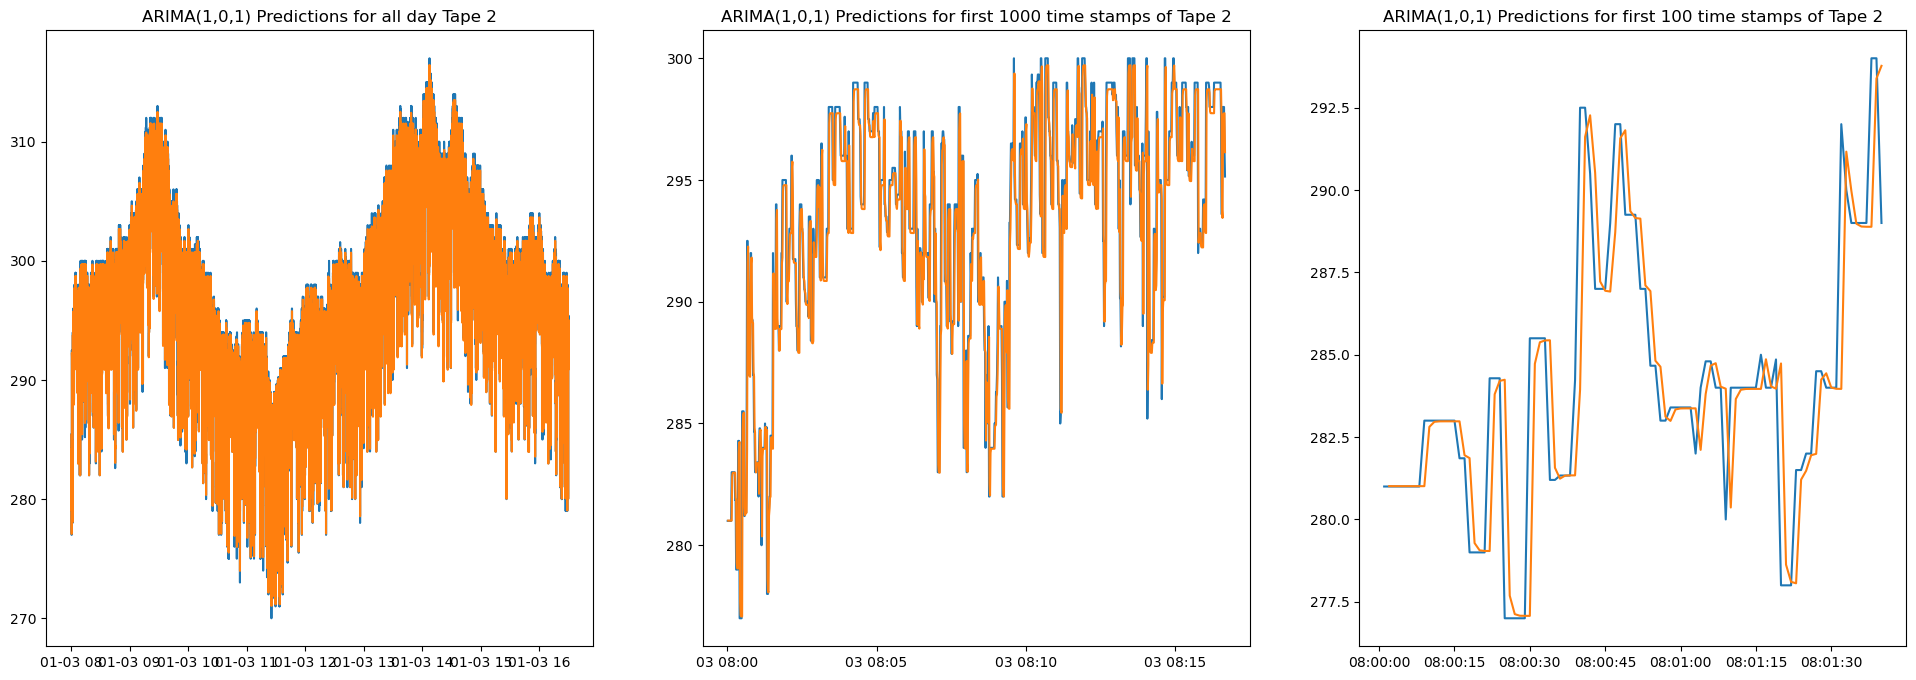

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

pred2 = result2.predict(start=0, end=len(tape2)-1)
ax1.plot(tape2['Last Tapes Price'])
ax1.plot(pred2[1:])
ax1.set_title('ARIMA(1,0,1) Predictions for all day Tape 2')

ax2.plot(tape2['Last Tapes Price'][:1000])
ax2.plot(pred2[1:1000])
ax2.set_title('ARIMA(1,0,1) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(tape2['Last Tapes Price'][:100])
ax3.plot(pred2[1:100]) 
ax3.set_title('ARIMA(1,0,1) Predictions for first 100 time stamps of Tape 2')

(array([3.75479444e-05, 2.06513694e-04, 3.37931500e-04, 7.69732861e-04,
        1.46436983e-03, 3.19157528e-03, 7.49081491e-03, 1.79291435e-02,
        4.59774579e-02, 3.80248033e-01, 6.45261425e-02, 2.16276160e-02,
        1.50754997e-02, 7.99771216e-03, 4.56207525e-03, 1.52069175e-03,
        8.63602722e-04, 4.13027389e-04, 1.12643833e-04, 7.50958888e-05]),
 array([-16.84348544, -15.10262088, -13.36175633, -11.62089177,
         -9.88002722,  -8.13916266,  -6.39829811,  -4.65743356,
         -2.916569  ,  -1.17570445,   0.56516011,   2.30602466,
          4.04688922,   5.78775377,   7.52861833,   9.26948288,
         11.01034744,  12.75121199,  14.49207655,  16.2329411 ,
         17.97380566]),
 <BarContainer object of 20 artists>)

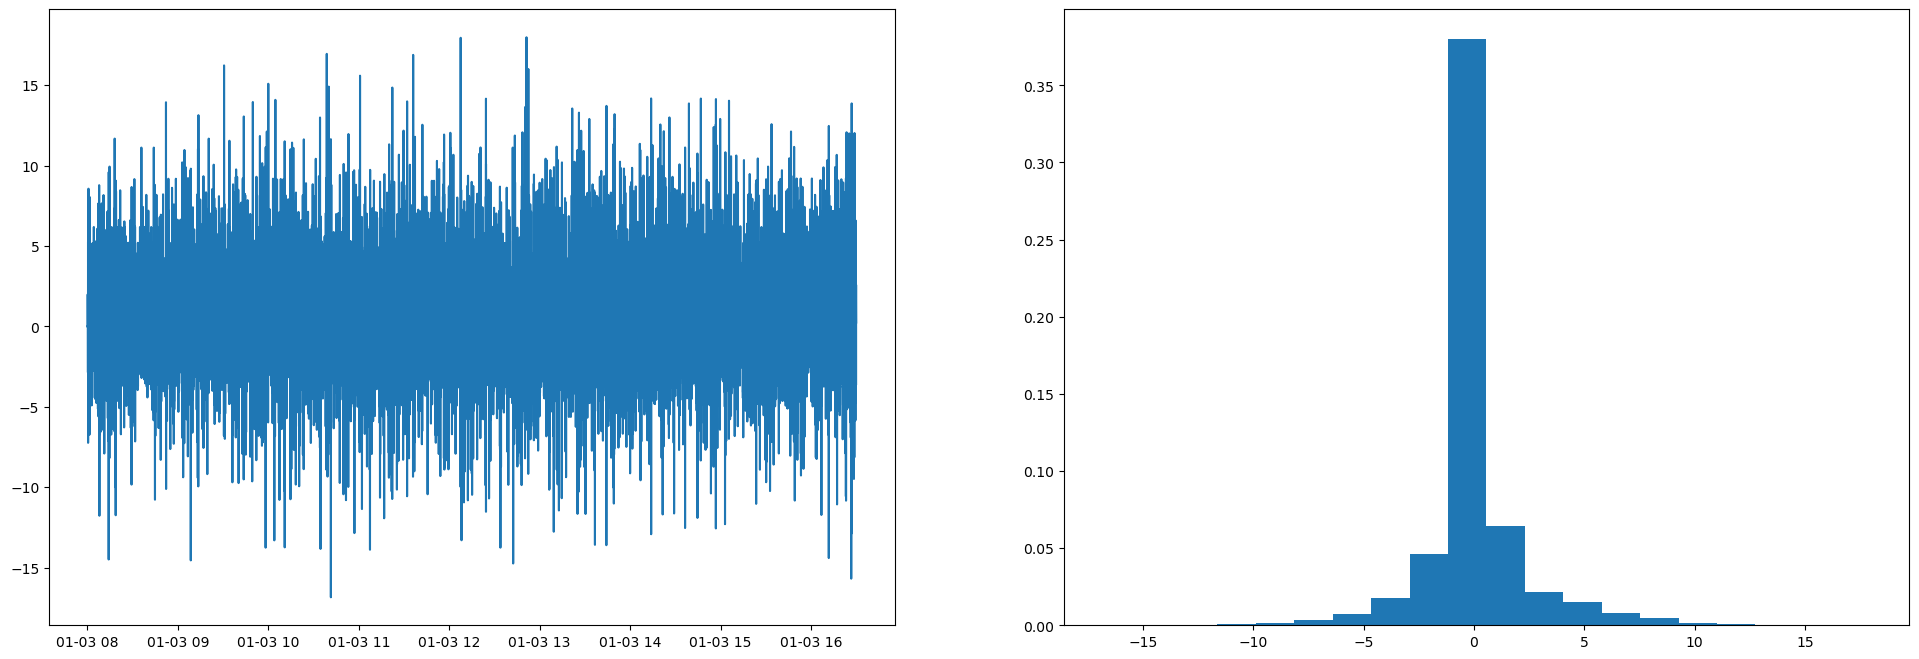

In [20]:
residuals2 = pd.DataFrame(result2.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals2[1:])
ax2.hist(residuals2[1:], density=True, bins=20)

Basic indicator using difference in price predicted

(array([1.45197738e-04, 6.01533486e-04, 2.71727195e-03, 1.50072233e-02,
        2.42729133e-01, 3.97634377e-02, 1.23521790e-02, 3.26694910e-03,
        6.32647287e-04, 1.03712670e-04]),
 array([-15.30962606, -12.15822604,  -9.00682603,  -5.85542601,
         -2.70402599,   0.44737402,   3.59877404,   6.75017406,
          9.90157407,  13.05297409,  16.20437411]),
 <BarContainer object of 10 artists>)

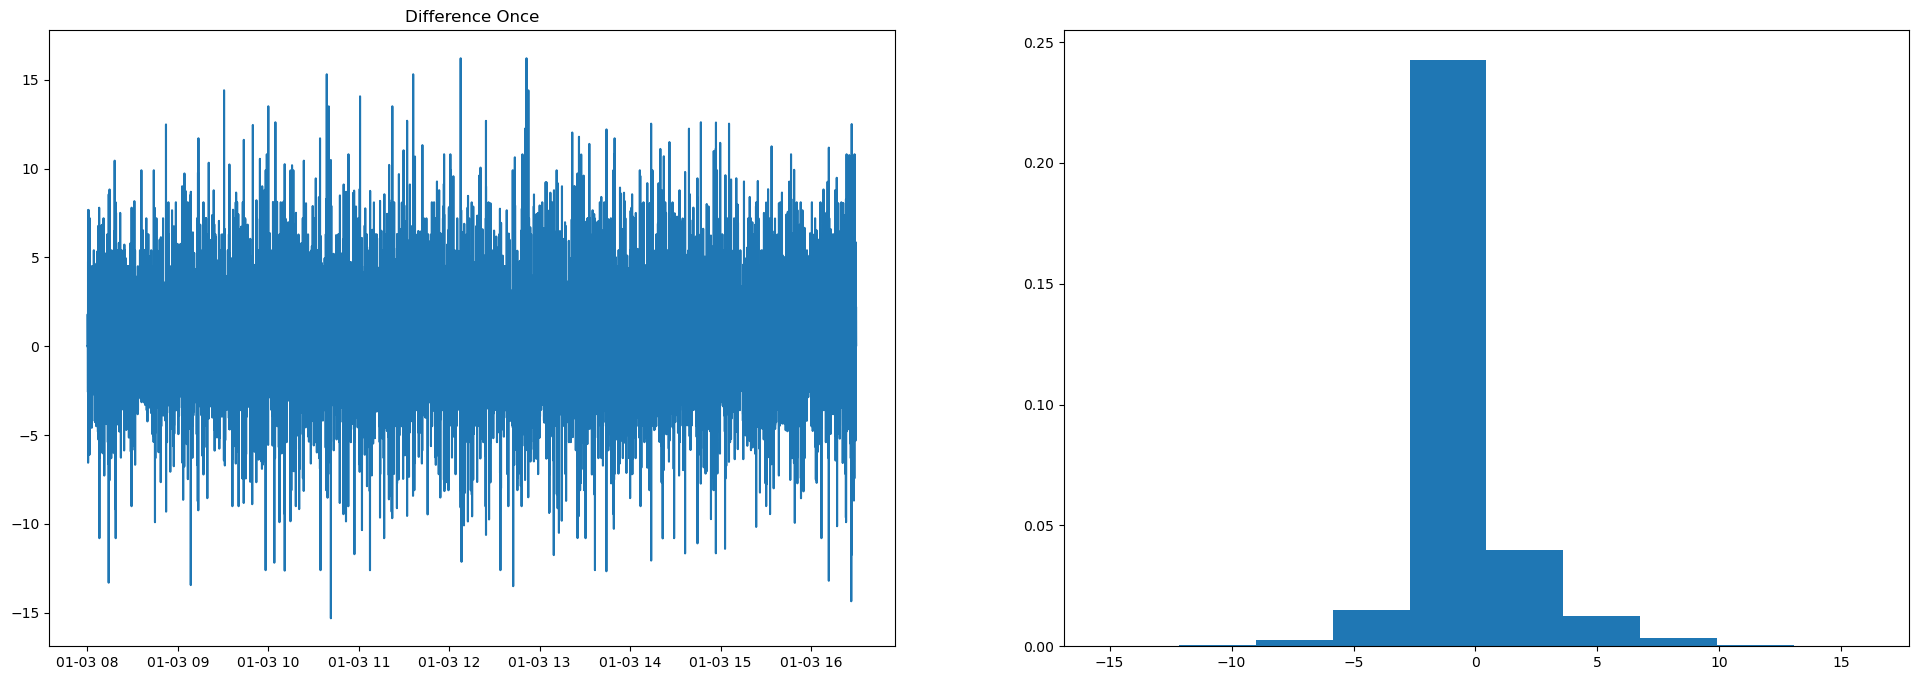

In [21]:
diff2 = pred2.diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff2[1:])
ax1.set_title('Difference Once')
ax2.hist(diff2[1:], density=True)

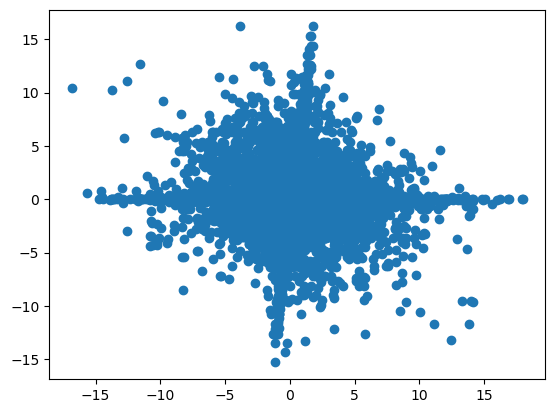

In [22]:
plt.scatter(residuals2[2:], diff2[1:])

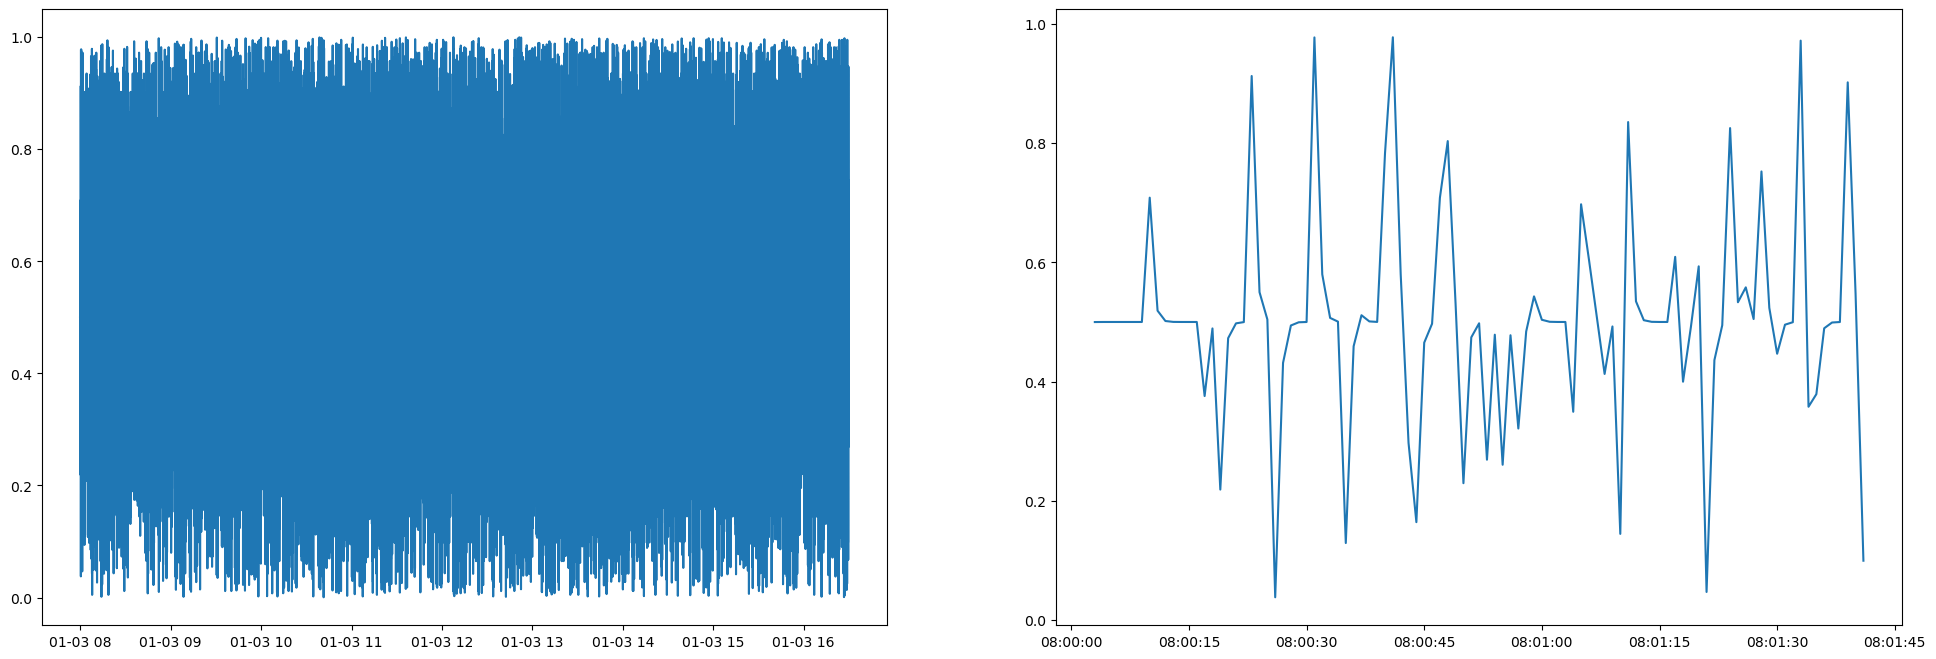

In [23]:
# pass differences through an activation function to get in 0-1 range for buy and sell signals - above 0.5 buy, below 0.5 sell
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# normalise distribtion to normal 
diff2_norm = (diff2 - diff2.mean()) / diff2.std()

singal_diff2 = sigmoid(diff2_norm)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))
ax1.plot(singal_diff2[1:])
ax2.plot(singal_diff2[1:100])

In [24]:
print('Tape 2 Error when trained on Tape 1')
print(f'Mean Absolute Error: {result2.mae}') 
print(f'MSE: {result2.mse}')

Tape 2 Error when trained on Tape 1
Mean Absolute Error: 1.2133316488541894
MSE: 5.056327973446794


Stationary Predicted Count: 17148
Stationary Actual Count: 18821
Stationary Correct Count: 10476
Upwards Predicted Count: 6145
Upwards Actual Count: 5157
Upwards Correct Count: 777
Downwards Predicted Count: 7304
Downwards Actual Count: 6619
Downwards Correct Count: 1625
0.42089093701996927


<AxesSubplot:xlabel='combined_time'>

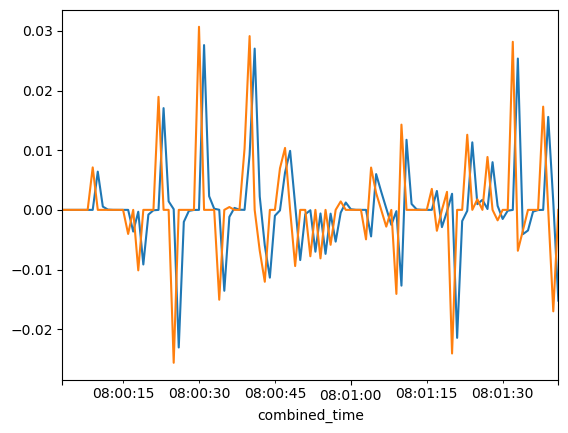

In [25]:
# check how many times signal has correctly predicted movement of actual price

# !!need to ensure that the price movement in in % values not absolute!!

# get actual price movement
actual_diff2 = tape2['Last Tapes Price'].pct_change().dropna()

pred2 = result2.predict(start=0, end=len(tape2)-1)
diff2 = pred2.pct_change().dropna()

threshold = 0.001

# check if both are over 1/100 of a % increase
up_correct = (diff2>threshold) & (actual_diff2>threshold)
down_correct = (diff2<-threshold) & (actual_diff2<-threshold)
stationary_correct = ((diff2<=threshold) & (diff2>-threshold)) & ((actual_diff2<=threshold) & (actual_diff2>-threshold))

print(f"Stationary Predicted Count: {sum((diff2<=threshold) & (diff2>-threshold))}")
print(f"Stationary Actual Count: {sum(((actual_diff2<=threshold) & (actual_diff2>-threshold)))}")
print(f"Stationary Correct Count: {sum(stationary_correct)}")

#correct = diff2_high*actual_diff2 > 0 # correct if direction is the same
#print(f"Stationary Predicted Count: {sum(diff2_high== 0)}")
#print(f"Stationary Actual Count: {sum(actual_diff2== 0)}")
# must also check if both are zero
#correct = correct | (diff2_high == 0) & (actual_diff2 == 0)
correct = up_correct | down_correct | stationary_correct
print(f"Upwards Predicted Count: {sum(diff2>threshold)}")
print(f"Upwards Actual Count: {sum(actual_diff2>threshold)}")
print(f"Upwards Correct Count: {sum(up_correct)}")
print(f"Downwards Predicted Count: {sum(diff2<-threshold)}")
print(f"Downwards Actual Count: {sum(actual_diff2<-threshold)}")
print(f"Downwards Correct Count: {sum(down_correct)}")
print(correct.sum()/len(correct))

diff2[1:100].plot()  
actual_diff2[1:100].plot()

In [27]:
model_high = ARIMA(tape1['Last Tapes Price'], order=(4,1,4))
result_high = model_high.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [34]:
result2_high = result_high.apply(tape2['Last Tapes Price'], refit=False)
result2_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Last Tapes Price   No. Observations:                30598
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -67352.952
Date:                Thu, 21 Mar 2024   AIC                         134723.904
Time:                        15:55:52   BIC                         134798.862
Sample:                    01-03-2025   HQIC                        134747.932
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0968      0.317     -0.306      0.760      -0.717       0.524
ar.L2          0.0916      0.285      0.322      0.748      -0.466       0.649
ar.L3          0.0203      0.281      0.072      0.942      -0.530       0.571
ar.L4          0.5118      0.238      2.153      0.031       0.046       0.978
ma.L1         -0.0476      0.318     -0.150      0.881      -0.671       0.576
ma.L2         -0.2305      0.318     -0.725      0.468      -0.854       0.393
ma.L3         -0.1113      0.296     -0.376      0.707      -0.691       0.468
ma.L4         -0.5802      0.278     -2.090      0.037      -1.124      -0.036
sigma2         5.0402      0.024    213.376      0.000       4.994       5.087
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             72787.35
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.54
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
print('Tape 2 Error when trained on Tape 1')
print(f'Mean Absolute Error: {result2_high.mae}') 
print(f'MSE: {result2_high.mse}')

Tape 2 Error when trained on Tape 1
Mean Absolute Error: 1.2904597318357078
MSE: 7.354757226871848


In [30]:
pred2_high = result2_high.predict(start=0, end=len(tape2)-1)
diff2_high = pred2_high.diff().dropna()

threshold = 0.0001

# check if both are over 1/100 of a % increase
up_correct = (diff2_high>threshold) & (actual_diff2>threshold)
down_correct = (diff2_high<-threshold) & (actual_diff2<-threshold)
stationary_correct = ((diff2_high<=threshold) & (diff2_high>-threshold)) & ((actual_diff2<=threshold) & (actual_diff2>-threshold))

print(f"Stationary Predicted Count: {sum((diff2_high<=threshold) & (diff2_high>-threshold))}")
print(f"Stationary Actual Count: {sum(((actual_diff2<=threshold) & (actual_diff2>-threshold)))}")

#correct = diff2_high*actual_diff2 > 0 # correct if direction is the same
#print(f"Stationary Predicted Count: {sum(diff2_high== 0)}")
#print(f"Stationary Actual Count: {sum(actual_diff2== 0)}")
# must also check if both are zero
#correct = correct | (diff2_high == 0) & (actual_diff2 == 0)
correct = up_correct | down_correct | stationary_correct

print(correct.sum()/len(correct))

Stationary Predicted Count: 47
Stationary Actual Count: 18359
0.18988789750629145


Use the model to make out of sample predictions

In [31]:
model = ARIMA(tape2['Last Tapes Price'][:20000], order=(4,1,4))
result3 = model.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [32]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Last Tapes Price   No. Observations:                20000
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -43929.962
Date:                Thu, 21 Mar 2024   AIC                          87877.923
Time:                        15:52:24   BIC                          87949.054
Sample:                    01-03-2025   HQIC                         87901.195
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1537     73.890     -0.002      0.998    -144.976     144.668
ar.L2          0.0302     53.295      0.001      1.000    -104.426     104.487
ar.L3          0.0898     44.299      0.002      0.998     -86.734      86.914
ar.L4          0.5364     45.304      0.012      0.991     -88.257      89.330
ma.L1          0.0081     73.891      0.000      1.000    -144.816     144.832
ma.L2         -0.1566     64.058     -0.002      0.998    -125.708     125.394
ma.L3         -0.1924     44.379     -0.004      0.997     -87.174      86.789
ma.L4         -0.6268     52.940     -0.012      0.991    -104.387     103.134
sigma2         4.7364      0.025    192.266      0.000       4.688       4.785
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             52353.39
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ValueError: x and y must have same first dimension, but have shapes (30590,) and (30598,)

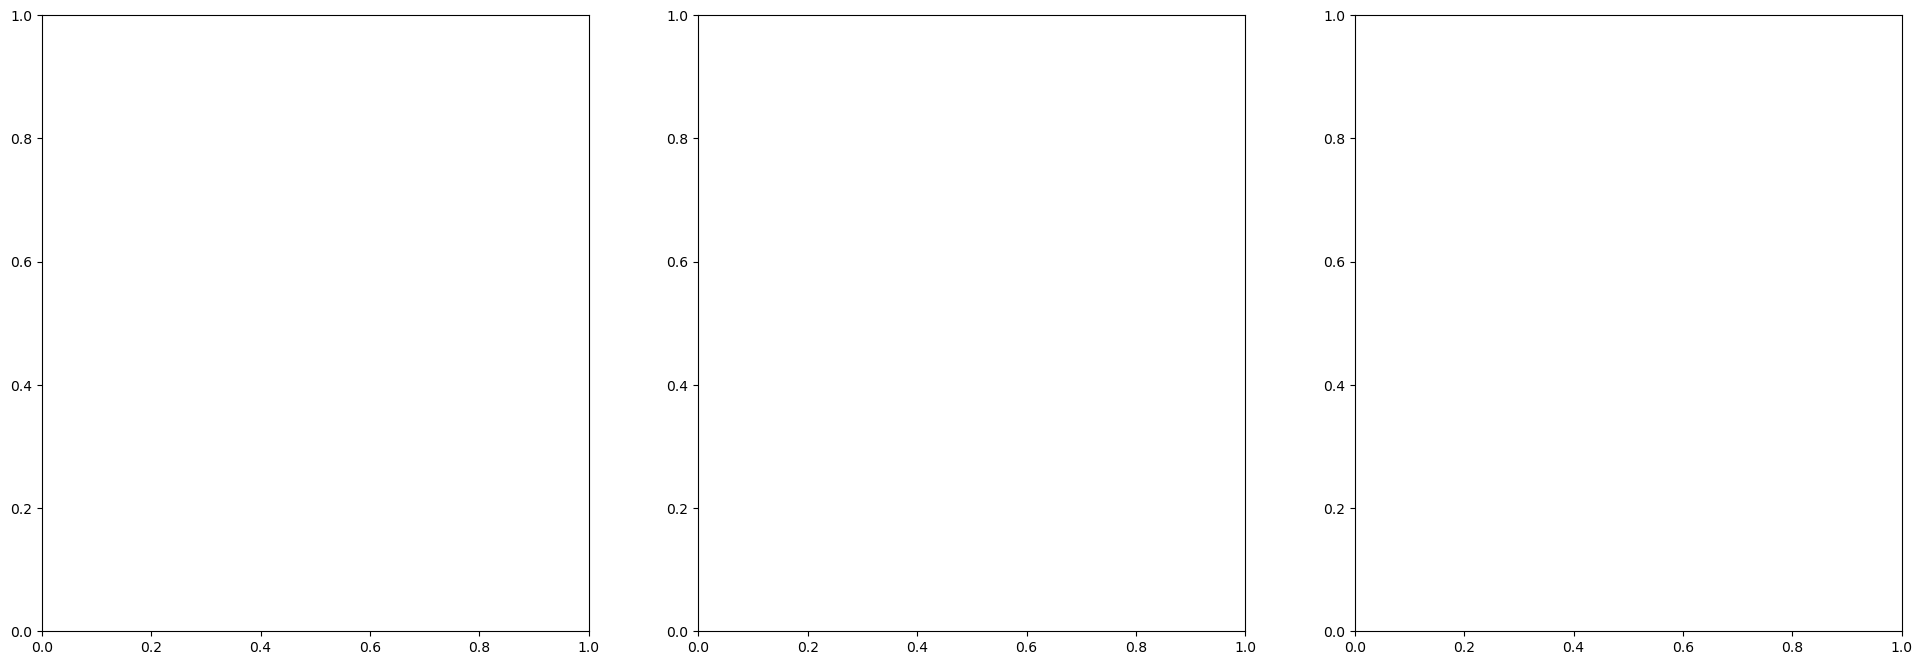

In [33]:
pred2 = result3.forecast(steps = 3810)
forecast_range = np.arange(20000,23810)
total_range = np.arange(0,30590)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

ax1.plot(total_range,tape2['Last Tapes Price'])
ax1.plot(forecast_range,pred2)
ax1.set_title('ARIMA(4,1,6) Predictions for all day Tape 2')

ax2.plot(forecast_range,tape2['Last Tapes Price'][20000:23810])
ax2.plot(forecast_range,pred2)
ax2.set_title('ARIMA(4,1,6) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(np.arange(20000,20100),tape2['Last Tapes Price'][20000:20100])
ax3.plot(forecast_range[0:99],pred2[1:100]) 
ax3.set_title('ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 2')